 #Transfer learning with tensorflow 
Transfer learning is leveraging a working model existing architecture and learning patterns for our own problem
there are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems 

In [ ]:
##downloading and becoming one with the data 
import zipfile
!wget = https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-04 08:41:27--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2022-10-04 08:41:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  48.1MB/s    in 3.3s    

2022-10-04 08:41:31 (48.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

FINISHED --2022-10-04 08:41:31--
Total wall clock time: 4.1s
Downloaded: 1 files, 161M in 3.3s (48.1 MB/s)


In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Creating data loaders(preparing the data)
1.Well use the ImageDataGenerator class to load in our images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/225)
test_datagen = ImageDataGenerator(rescale=1/225)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##setting up callbacks

callback are extra functionality you can add to your models to be performed during or after training. some of thr ost popular callbacks:
* Tracking experiments woth the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* stopping a model from training(before it trains too long and overfits) with Early Stopping callbacks

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
#lets compar the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientsnet_url= "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [ ]:
#Dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
#LEts make acreate model function
def create_model(model_url, num_classes=10):
   """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  #Download the pretrained model and save it as a keras layer
   feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
   
   #Create our own model
   model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax", name="output_layer") 
   ])


   return model

#### Creating and testing Resnet tensorflow hub feature extraction model

In [ ]:
#create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
#compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
#fit model
resnet_history= resnet_model.fit(train_data_10_percent, epochs=5,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data_10_percent,
                 validation_steps= len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                       experiment_name="resnet50v2"
                                                       )])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20221004-095524
Epoch 1/5
24/24 [==============================] - 15s 430ms/step - loss: 1.8643 - accuracy: 0.3800 - val_loss: 1.1661 - val_accuracy: 0.6380
Epoch 2/5
24/24 [==============================] - 9s 380ms/step - loss: 0.8998 - accuracy: 0.7267 - val_loss: 0.8886 - val_accuracy: 0.7122
Epoch 3/5
24/24 [==============================] - 9s 378ms/step - loss: 0.6265 - accuracy: 0.8027 - val_loss: 0.7802 - val_accuracy: 0.7448
Epoch 4/5
24/24 [==============================] - 9s 381ms/step - loss: 0.4797 - accuracy: 0.8720 - val_loss: 0.6772 - val_accuracy: 0.7812
Epoch 5/5
24/24 [==============================] - 9s 379ms/step - loss: 0.3883 - accuracy: 0.9107 - val_loss: 0.7582 - val_accuracy: 0.7630


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 834,666
Trainable params: 5,130
Non-trainable params: 829,536
_________________________________________________________________


In [ ]:
#lets create a function to plot loss curves 
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

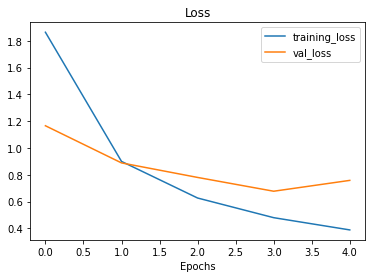

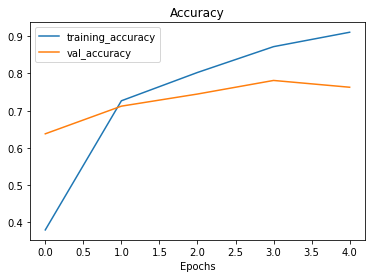

In [ ]:
plot_loss_curves(resnet_history)

###Creating efficient net


In [ ]:
#Create model
efficientnet_model= create_model(efficientsnet_url,
                                 num_classes=train_data_10_percent.num_classes)

In [ ]:
#compile model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
#fit model
efficientnet_history= efficientnet_model.fit(train_data_10_percent, epochs=5,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data_10_percent,
                 validation_steps= len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                       experiment_name="efficientnetb0"
                                                       )])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221004-104041
Epoch 1/5
24/24 [==============================] - 13s 409ms/step - loss: 1.8931 - accuracy: 0.4120 - val_loss: 1.3425 - val_accuracy: 0.6862
Epoch 2/5
24/24 [==============================] - 9s 371ms/step - loss: 1.0944 - accuracy: 0.7520 - val_loss: 0.9013 - val_accuracy: 0.7982
Epoch 3/5
24/24 [==============================] - 7s 309ms/step - loss: 0.7822 - accuracy: 0.8160 - val_loss: 0.7831 - val_accuracy: 0.7799
Epoch 4/5
24/24 [==============================] - 7s 306ms/step - loss: 0.6297 - accuracy: 0.8587 - val_loss: 0.6332 - val_accuracy: 0.8398
Epoch 5/5
24/24 [==============================] - 7s 309ms/step - loss: 0.5341 - accuracy: 0.8907 - val_loss: 0.5917 - val_accuracy: 0.8490


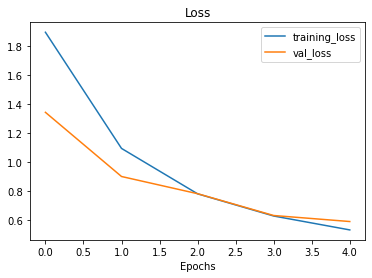

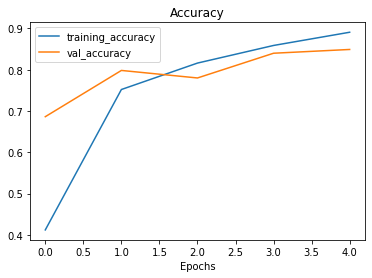

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
### creating a helper functions
